In [85]:
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [86]:
test = pd.read_csv('C:/Users/david/Downloads/covid_testing_data.csv')

country_cond = test['country'].isin(["Denmark", "Germany", "Romania", "Spain", "Sweden"])
level_cond = test['level'] == 'national'

test = (
    test[country_cond & level_cond]
    .drop(['level', 'region_name'], axis = 1)
)

In [87]:
test['date'] = test.apply(lambda x: datetime.datetime.strptime(x['year_week'] + '-1', "%Y-W%W-%w"), axis=1)
test['month'] = test.apply(lambda x: x.date.month, axis = 1)
test = test.drop('date', axis = 1)
test.head(5)

,country,country_code,year_week,region,new_cases,tests_done,population,testing_rate,positivity_rate,testing_data_source,month
385,Denmark,DK,2020-W05,DK,0,3,5806081.0,0.051670,0.000000,Country website,2
386,Denmark,DK,2020-W06,DK,0,4,5806081.0,0.068893,0.000000,Country website,2
387,Denmark,DK,2020-W07,DK,0,4,5806081.0,0.068893,0.000000,Country website,2
388,Denmark,DK,2020-W08,DK,0,9,5806081.0,0.155010,0.000000,Country website,2
389,Denmark,DK,2020-W09,DK,4,337,5806081.0,5.804259,1.186944,Country website,3


In [88]:
year_cond = test.year_week.str.startswith('2020')
test = test[year_cond]

In [89]:
list_year_week = test['year_week'].str.split('-W')

test['year'] = [elem[0] for elem in list_year_week]

In [90]:
agg_df = test\
.groupby(['year','month', 'country', 'country_code'])\
.agg({'new_cases': 'sum', 'tests_done': 'sum', 'population': 'mean'})\
.reset_index()

In [91]:
# data quality issues with Romania in 2020-03 (much more cases than tests)
agg_df[agg_df['country_code'] == 'RO'].head(5)

,year,month,country,country_code,new_cases,tests_done,population
2,2020,1,Romania,RO,22000,87761,19414458.0
9,2020,3,Romania,RO,1621,14,19414458.0
13,2020,4,Romania,RO,7172,100268,19414458.0
17,2020,5,Romania,RO,7034,219393,19414458.0
22,2020,6,Romania,RO,8243,316517,19414458.0


In [92]:
agg_df['testing_rate'] = agg_df['tests_done'] / agg_df['population'] * 100
agg_df['positivity_rate'] = agg_df['new_cases'] / agg_df['tests_done'] * 100
agg_df['year_month'] = agg_df['year'] + '-' + agg_df['month'].astype('str')

# Data quality filtering
agg_df = agg_df[agg_df['positivity_rate'] <= 100]

In [93]:
plt.style.use('ggplot')

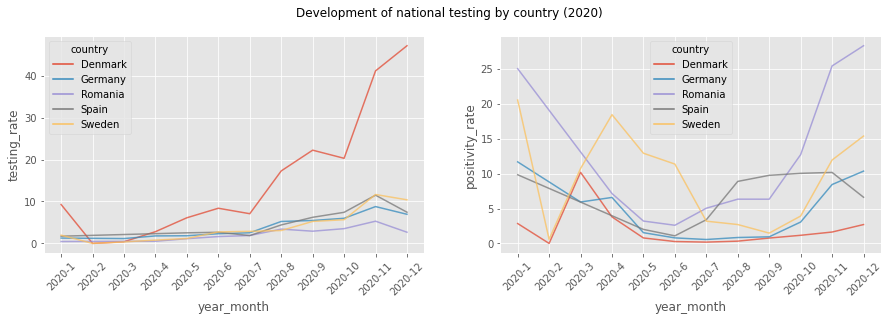

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4))

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

fig.suptitle('Development of national testing by country (2020)')
sns.lineplot(x = 'year_month', y = 'testing_rate', data = agg_df, hue = 'country', alpha = .75, ax=ax1)
sns.lineplot(x = 'year_month', y = 'positivity_rate', data = agg_df, hue = 'country', alpha = .75, ax=ax2);